# Surrogate models for climate metrics

The purpose of this notebook is to provide regression models to calculate climate metrics as functions of time horizon and aviation species settings (sensitivity to emissions, ERF/RF and efficacy):
$$ Metric = f(H, \sigma, \eta, r) $$

The regression models are fitted here on FaIR's outputs.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import qmc
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from aerometrics.utils.functions import emission_profile_function
from aerometrics.metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from aerometrics.climate_models.co2_ipcc_climate_model import co2_ipcc_climate_model
from aerometrics.climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model

## Sampling

In [2]:
# Define variable bounds (in log-space)
variables = {"time_horizon_log": (np.log(10), np.log(200))}

# Generate Latin Hypercube samples
n_samples = 100
sampler = qmc.LatinHypercube(d=len(variables))
sample = sampler.random(n=n_samples)  # scaled between 0 and 1

# Rescale samples to variable bounds
l_bounds, u_bounds = zip(*variables.values())
scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

# Round to integer years in original space, then convert back to log --> ensure further processing with time horizons will use int years
scaled_sample = np.log(np.exp(scaled_sample).astype(int))
df_samples = pd.DataFrame(scaled_sample, columns=variables.keys())
df_samples

,time_horizon_log
0,4.330733
1,3.713572
2,5.252273
3,3.663562
4,2.833213
...,...
95,3.178054
96,3.806662
97,2.639057
98,4.543295


## Calculate metrics

In [5]:
# Species settings
SPECIES_SETTINGS = {
    "Aviation contrails": {
        "sensitivity_rf": 2.23e-12,
        "ratio_erf_rf": 0.42,
        "efficacy_erf": 1.0,
    },
    "Aviation NOx - ST O3 increase": {
        "sensitivity_rf": 25.1e-12 * (14 / 46),
        "ratio_erf_rf": 1.37,
        "efficacy_erf": 1.0,
    },
    "Aviation NOx - CH4 decrease and induced": {
        "sensitivity_rf": -3.90,
        "ratio_erf_rf": 1.18,
        "efficacy_erf": 1.0,
    },
}
unit_value = 1*10**10

# CO2 settings
species_settings_co2 = {
    "sensitivity_rf": 9.2e-16, 
    "ratio_erf_rf": 1.0, 
    "efficacy_erf": 1.0
}
unit_value_co2 = 1*10**10

# Time settings
start_year = 1765
t0 = 2020

# repare collection for results
all_results = []

# Loop over each species
for species, species_settings in SPECIES_SETTINGS.items():
    print(f"\n Computing metrics for {species}...")

    species_results = []
    
    # Loop over each time horizon sample
    for i, log_horizon in tqdm(enumerate(df_samples["time_horizon_log"]), total=n_samples, leave=False):
        time_horizon = int(np.exp(log_horizon))  # integer time horizons are required by aerometrics functions
        end_year = t0 + time_horizon

        # Background / model settings
        background_species_quantities = background_species_quantities_function(
            start_year, end_year, rcp="RCP45"
        )
        model_settings = {"background_species_quantities": background_species_quantities}

        # CO2 absolute metrics
        emission_profile_co2 = emission_profile_function(start_year, t0, time_horizon, "pulse", unit_value_co2)
        rf_co2, erf_co2, temp_co2 = species_fair_climate_model(
            start_year, end_year, "Aviation CO2",
            emission_profile_co2, species_settings_co2, model_settings
        )
        rf_co2_u, erf_co2_u, temp_co2_u = rf_co2 / unit_value_co2, erf_co2 / unit_value_co2, temp_co2 / unit_value_co2

        agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(
            rf_co2_u, erf_co2_u, species_settings_co2["efficacy_erf"], temp_co2_u, time_horizon
        )

        # Species-specific
        emission_profile = emission_profile_function(start_year, t0, time_horizon, "pulse", unit_value)
        rf, erf, temp = species_fair_climate_model(
            start_year, end_year, species, emission_profile, species_settings, model_settings
        )
        rf_u, erf_u, temp_u = rf / unit_value, erf / unit_value, temp / unit_value

        agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(
            rf_u, erf_u, species_settings["efficacy_erf"], temp_u, time_horizon
        )

        gwp_rf, gwp_erf, egwp_rf, egwp_erf, gtp, igtp, ratr = relative_metrics(
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2,
            agtp_co2, iagtp_co2, atr_co2,
            agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr
        )

        species_results.append({
            "species": species,
            "time_horizon": time_horizon,
            "GWP_RF": gwp_rf,
            "GWP_ERF": gwp_erf,
            "EGWP_RF": egwp_rf,
            "EGWP_ERF": egwp_erf,
            "GTP": gtp,
            "iGTP": igtp,
            "RATR": ratr,
        })

    all_results.extend(species_results)

# Combine results for all species
df = pd.DataFrame(all_results)
print(df.head())


 Computing metrics for Aviation contrails...



 Computing metrics for Aviation NOx - ST O3 increase...



 Computing metrics for Aviation NOx - CH4 decrease and induced...


              species  time_horizon      GWP_RF    GWP_ERF    EGWP_RF  \
0  Aviation contrails            76   31.819540  13.364207  13.364207   
1  Aviation contrails            41   51.851614  21.777678  21.777678   
2  Aviation contrails           191   14.778129   6.206814   6.206814   
3  Aviation contrails            38   55.016871  23.107086  23.107086   
4  Aviation contrails            17  103.255619  43.367360  43.367360   

    EGWP_ERF       GTP       iGTP       RATR  
0  13.364207  1.916542  15.055439  15.055439  
1  21.777678  2.486909  24.790264  24.790264  
2   6.206814  0.897581   7.103993   7.103993  
3  23.107086  2.597560  26.401464  26.401464  
4  43.367360  7.655692  52.861980  52.861980  


## Fit regression models

### Model 1 (power law)
$$ \log(\text{metric}) = a_1 + b_1 \log(\text{time horizon}) $$
$$ \text{metric} = e^{a_1} \text{time horizon}^{b_1} $$

### Model 2 (log-quadratic model)
$$ \log(\text{metric}) = a_2 + b_2 \log(\text{time horizon}) + c_2 [\log(\text{time horizon})]^2 $$
$$ \text{metric} = e^{a_2} \text{time horizon}^{b_2 + c_2 \log(\text{time horizon})} $$

In [21]:
def fit_log_models(df, species, metric):
    """
    Fit two regression models for a given species and metric:
      - Model 1: linear in log(feature)
      - Model 2: quadratic in log(feature)
    
    Args:
        df (pd.DataFrame): DataFrame containing columns ['species', 'time_horizon', metric]
        species (str): species name to filter the data
        metric (str): column name of the metric to fit
        
    Returns:
        dict: containing Model1, Model2, analytical expressions, and errors
    """
    # Filter data for species
    df_s = df[df["species"] == species].copy()
    if df_s.empty:
        raise ValueError(f"No data found for species '{species}'")
    
    # Prepare features
    X = df_s[["time_horizon"]].copy()
    X["time_horizon_log"] = np.log(X["time_horizon"])
    X["time_horizon_log_2"] = X["time_horizon_log"] ** 2
    y = np.log(df_s[metric]) if species != "Aviation NOx - CH4 decrease and induced" else np.log(-df_s[metric])
    
    # Model 1: linear in log(time_horizon)
    model1 = LinearRegression().fit(X[["time_horizon_log"]], y)
    a1 = model1.intercept_
    b1 = model1.coef_[0]
    eq1_log = f"log({metric}) = {a1:.4f} + {b1:.4f} × log(time_horizon)"
    eq1 = f"{metric} = {np.exp(a1):.4f} × time_horizon^{b1:.4f}"
    y_pred1 = model1.predict(X[["time_horizon_log"]])
    r2_1 = r2_score(np.exp(y), np.exp(y_pred1))
    
    # Model 2: quadratic in log(time_horizon)
    model2 = LinearRegression().fit(X[["time_horizon_log", "time_horizon_log_2"]], y)
    a2 = model2.intercept_
    b2, c2 = model2.coef_
    eq2_log = f"log({metric}) = {a2:.4f} + {b2:.4f} × log(time_horizon) + {c2:.4f} × log(time_horizon)^2"
    eq2 = f"{metric} = {np.exp(a2):.4f} × time_horizon^({b2:.4f} + {c2:.4f} × log(time_horizon))"
    y_pred2 = model2.predict(X[["time_horizon_log", "time_horizon_log_2"]])
    r2_2 = r2_score(np.exp(y), np.exp(y_pred2))
    
    return {
        "Model1": model1,
        "Model2": model2,
        "eq1_log": eq1_log,
        "eq1": eq1,
        "eq2_log": eq2_log,
        "eq2": eq2,
        "R2_1": r2_1,
        "R2_2": r2_2,
        "df": pd.DataFrame({"y": np.exp(y), "y_pred1": np.exp(y_pred1), "y_pred2": np.exp(y_pred2)})
    }


def plot_surrogate(results, bin_width: float = 1.0):
    """
    Plot the results of the model fitting with an observed-estimated chart and an histogram of errors.
    """
    # Retrieve results
    y = results["df"]["y"]
    y_pred1 = results["df"]["y_pred1"]
    y_pred2 = results["df"]["y_pred2"]
    residuals_1 = (y_pred1 - y) / y * 100
    residuals_2 = (y_pred2 - y) / y * 100
    mean_error1 = np.mean(residuals_1)
    mean_error2 = np.mean(residuals_2)
    r21 = results['R2_1']
    r22 = results['R2_2']

    # Set figures
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Observed-estimated chart
    axes[0].scatter(y, y_pred1, label='Model 1 - '+f'R² = {r21:.3f}', alpha=0.7)
    axes[0].scatter(y, y_pred2, label='Model 2 - '+f'R² = {r22:.3f}', alpha=0.7)
    axes[0].plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], color='black')
    axes[0].set_xlabel(r"Observed")
    axes[0].set_ylabel(r"Estimated")
    axes[0].legend()
    axes[0].grid(True)

    # Regression errors histogram
    combined_min = min(residuals_1.min().item(), residuals_2.min().item())
    combined_max = max(residuals_1.max().item(), residuals_2.max().item())
    bins = np.arange(combined_min, combined_max + bin_width, bin_width)
    axes[1].hist(residuals_1, bins=bins, color='C0', edgecolor='black', alpha=0.7)
    axes[1].hist(residuals_2, bins=bins, color='C1', edgecolor='black', alpha=0.7)
    axes[1].axvline(mean_error1, color='C0', linestyle='--', linewidth=2, label='Model 1 - '+f'Mean error: {mean_error1:.2f}')
    axes[1].axvline(mean_error2, color='C1', linestyle='--', linewidth=2, label='Model 2 - 'f'Mean error: {mean_error2:.2f}')
    axes[1].set_xlabel("Relative Error [%]")
    axes[1].set_ylabel("Frequency [%]")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    return fig, axes

## Applications

### r-ATR for NOx

RATR = 2580.2386 × time_horizon^-0.6544
RATR = 648.6876 × time_horizon^(0.1214 + -0.1030 × log(time_horizon))
Model 1 R²: 0.9606
Model 2 R²: 0.9985


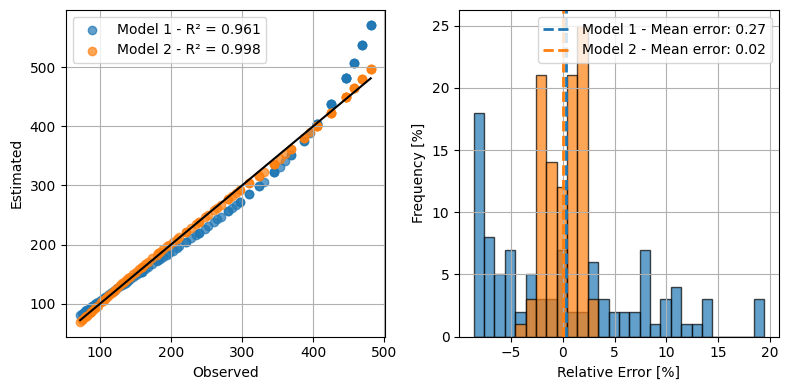

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Observed', ylabel='Estimated'>,
        <Axes: xlabel='Relative Error [%]', ylabel='Frequency [%]'>],
       dtype=object))

In [22]:
# Set species and metric to estimate
species="Aviation NOx - CH4 decrease and induced"
metric="RATR"

# Get results
results = fit_log_models(df, species=species, metric=metric)
print(results["eq1"])
print(results["eq2"])
print(f"Model 1 R²: {results['R2_1']:.4f}")
print(f"Model 2 R²: {results['R2_2']:.4f}")
plot_surrogate(results)
#plt.savefig("figures/surrogate_model.pdf")

### EGWP for contrails

EGWP_ERF = 414.2507 × time_horizon^-0.7952
EGWP_ERF = 356.2962 × time_horizon^(-0.7105 + -0.0112 × log(time_horizon))
Model 1 R²: 0.9999
Model 2 R²: 0.9999


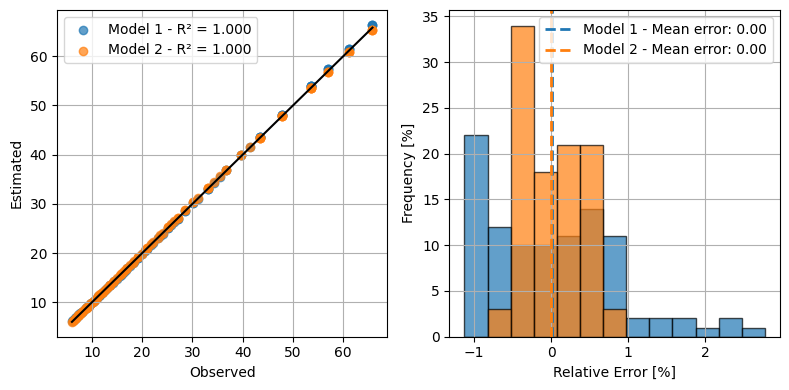

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Observed', ylabel='Estimated'>,
        <Axes: xlabel='Relative Error [%]', ylabel='Frequency [%]'>],
       dtype=object))

In [23]:
# Set species and metric to estimate
species="Aviation contrails"
metric="EGWP_ERF"

# Get results
results = fit_log_models(df, species=species, metric=metric)
print(results["eq1"])
print(results["eq2"])
print(f"Model 1 R²: {results['R2_1']:.4f}")
print(f"Model 2 R²: {results['R2_2']:.4f}")
plot_surrogate(results, bin_width=0.3)
#plt.savefig("figures/surrogate_model.pdf")